# PREDICTING SEPSIS RISK DURING IN-PATIENT ADMISSIONS
*Client: Royal Perth Hospital*

*Team: Group 7*

# Readme
The following libraries need to be installed in order to run the source code.

In [2]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

np.warnings = warnings

In [3]:
import sys
sys.path.append("..")

# import utility functions
import src.utils as util
reload(util)

import src.load_parquet as load_parquet
reload(load_parquet)

# setup OS agnostic pathnames
ROOT_DIR = Path('..')

# Note: to run main notebook from root directory, use:
# ROOT_DIR = Path('')

import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

import src.modelling_pipeline as models
reload(models)

mp = models.ModelPipeline(ROOT_DIR)

In [4]:
# load libraries and modules
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report 
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay

# 1.Dataset Processing

Load the dataset. The following tables are loaded for this project:
- PATIENTS
- ADMISSIONS
- DIAGNOSES_ICD
- LABEVENTS
- MICROBIOLOGYEVENTS
- D_ICD_DIAGNOSES
- D_ITEMS

In [5]:
path_patients = ROOT_DIR / 'data' / "PATIENTS.csv"  
path_admissions = ROOT_DIR / 'data' / "ADMISSIONS.csv"
path_diagnoses_icd = ROOT_DIR / 'data' / "DIAGNOSES_ICD.csv"
path_labevents = ROOT_DIR / 'data' / "LABEVENTS.csv"
path_microbiologyevents = ROOT_DIR / 'data' / "MICROBIOLOGYEVENTS.csv"
path_desc_icd = ROOT_DIR / 'data' / "D_ICD_DIAGNOSES.csv"
path_desc_labitems = ROOT_DIR / 'data' / "D_LABITEMS.csv"
path_desc_items = ROOT_DIR / 'data' /  "D_ITEMS.csv"

In [6]:
# load transaction dataset
df_patients_full = pd.read_csv(path_patients)
df_admissions_full = pd.read_csv(path_admissions)
df_diagnoses_icd_full = pd.read_csv(path_diagnoses_icd)
df_labevents_full = pd.read_csv(path_labevents)
df_microbiologyevents_full = pd.read_csv(path_microbiologyevents)

# load description tables
df_desc_icd_full = pd.read_csv(path_desc_icd)
df_desc_labitems_full = pd.read_csv(path_desc_labitems)
df_desc_items_full = pd.read_csv(path_desc_items)

## 1.1 Data Cleaning

In [8]:
# Convert the following datetime columns to datetime format
# patients: DOB to date format, we not care about the birth time
df_patients_full['DOB'] = pd.to_datetime(df_patients_full['DOB'], format='%Y-%m-%d %H:%M:%S')
# admissions: ADMITTIME, DISCHTIME, EDREGTIME, EDOUTTIME
df_admissions_full['ADMITTIME'] = pd.to_datetime(df_admissions_full['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
df_admissions_full['DISCHTIME'] = pd.to_datetime(df_admissions_full['DISCHTIME'], format='%Y-%m-%d %H:%M:%S')
# labevents: CHARTTIME
df_labevents_full['CHARTTIME'] = pd.to_datetime(df_labevents_full['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')
# microbiologyevents: CHARTDATE to date format and CHARTTIME to datetime format
df_microbiologyevents_full['CHARTDATE'] = pd.to_datetime(df_microbiologyevents_full['CHARTDATE'], format='%Y-%m-%d %H:%M:%S')
df_microbiologyevents_full['CHARTTIME'] = pd.to_datetime(df_microbiologyevents_full['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')

The DIAGNOSES_ICD tables has a column ICD9_CODE which is the code for each disease diagnosed for the patient.

The Sepsis has 6 codes: ['77181', '99591', '99592', '67020', '67022', '67024']

We'll introduce a new column, IS_SEPSIS, as a binary classifier (1 for 6 sepsis ICD9 codes, 0 otherwise) for the target variable.

In [9]:
# retrieve all sepsis icd code
sepsis_icd =  df_desc_icd_full[df_desc_icd_full.apply(lambda x:'sepsis' in x['SHORT_TITLE'].lower(),axis=1)]['ICD9_CODE'].values
# add new binary classifier target variable
df_diagnoses_icd_full['IS_SEPSIS'] = df_diagnoses_icd_full.apply(lambda x: 1 if x['ICD9_CODE'] in sepsis_icd else 0, axis=1)

In [10]:
# create function for checking the admission diagnoses to find whether it is diagnosed sepsis
def check_sepsis(subject_id, hadm_id, df_diagnoses_icd):
    admission_diagnoses = df_diagnoses_icd_full[(df_diagnoses_icd_full['SUBJECT_ID'] == subject_id) & (df_diagnoses_icd_full['HADM_ID'] == hadm_id)]
    is_sepsis = 1 if sum(admission_diagnoses['IS_SEPSIS']) > 0 else 0
    return is_sepsis

In [11]:
# create demographic df and save to csv file for future load
try:
    pathname_demographic = ROOT_DIR / 'data' / 'demographic.csv'
    df_demographic_full = pd.read_csv(pathname_demographic)
except:
    # merge the patients and admission tables to a demographic dataframe
    df_demographic_full = pd.merge(df_admissions_full, df_patients_full[['SUBJECT_ID', 'GENDER', 'DOB', 'EXPIRE_FLAG']], on='SUBJECT_ID')
    # create an age column to each case
    df_demographic_full['AGE'] = (((df_demographic_full['ADMITTIME'].dt.date - df_demographic_full['DOB'].dt.date) // 365) / pd.Timedelta(days=1)).astype('int16')
    # add column IS_SEPSIS to demographic data indicating which case is diagnosed with sepsis
    df_demographic_full['IS_SEPSIS'] = df_demographic_full.apply(lambda x: check_sepsis(x['SUBJECT_ID'], x['HADM_ID'], df_diagnoses_icd_full), axis=1)
    util.save_csv(df_demographic_full, ROOT_DIR / 'data' / 'demographic_full.csv')

# convert admittime and dischtime to datetime
df_demographic_full['ADMITTIME'] = pd.to_datetime(df_demographic_full['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
df_demographic_full['DISCHTIME'] = pd.to_datetime(df_demographic_full['DISCHTIME'], format='%Y-%m-%d %H:%M:%S')

In [12]:
# create age category 
df_demographic_full = util.categorise_age(df_demographic_full)

<Axes: title={'center': 'AGE'}, xlabel='IS_SEPSIS'>

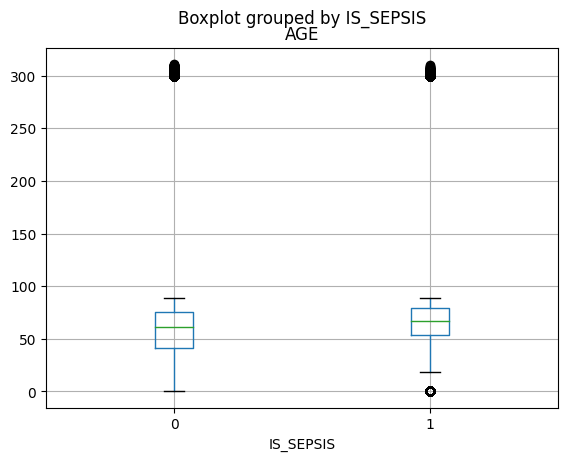

In [13]:
# plotting the age of admissions
df_demographic_full.boxplot(column=['AGE'], by='IS_SEPSIS')

In [14]:
count_over100 = len(df_demographic_full[df_demographic_full.AGE>100])
p_over100 = len(df_demographic_full[df_demographic_full.AGE>100])/len(df_demographic_full)*100
median_age = int(df_demographic_full['AGE'].median())
print('The number of admissions aged over 100 years old is: {} admissions ({:.2f}% over all admissions)'.format(count_over100, p_over100))
print('The median age of patients: {}'.format(median_age))

The number of admissions aged over 100 years old is: 2616 admissions (4.44% over all admissions)
The median age of patients: 61


Load unpivoted labevents dataframe:

In [15]:
output_dir = ROOT_DIR / 'data' / 'labevents_transform_parquet'
df_labevents_processed = load_parquet.load_labevents_dask(output_dir)

2023-10-10 12:25:25.018253 Start
2023-10-10 12:25:25.944798 2045381
2023-10-10 12:25:29.875094 End


In [153]:
df_labevents_full.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN
1,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN
2,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN
3,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal
5,286,3,NaN,50812,2101-10-12 18:17:00,NOT INTUBATED,NaN,NaN,NaN
6,287,3,NaN,50813,2101-10-12 18:17:00,1.8,1.80,mmol/L,NaN
7,288,3,NaN,50818,2101-10-12 18:17:00,33,33.00,mm Hg,NaN
8,289,3,NaN,50820,2101-10-12 18:17:00,7.42,7.42,units,NaN
9,290,3,NaN,50821,2101-10-12 18:17:00,80,80.00,mm Hg,NaN


In [155]:
# Read LABEVENTS.csv and filter rows where HADM_ID is missing

# Read ADMISSIONS.csv
df_empty_hadm_labevents = df_labevents_full[df_labevents_full['HADM_ID'].isnull()]
df_filled_hadm_labevents = df_labevents_full[pd.to_numeric(df_labevents_full["HADM_ID"], errors='coerce').notnull()]

df_admissions_full.sort_values(by=["SUBJECT_ID", "ADMITTIME"], inplace=True)
df_empty_hadm_labevents.sort_values(by=["SUBJECT_ID", "CHARTTIME"], inplace=True)

# Sorting both DataFrames by the keys used for merging

df_admissions_full['ADMITTIME'] = pd.to_datetime(df_admissions_full['ADMITTIME'])
df_admissions_full['DISCHTIME'] = pd.to_datetime(df_admissions_full['DISCHTIME'])
df_empty_hadm_labevents['CHARTTIME'] = pd.to_datetime(df_empty_hadm_labevents['CHARTTIME']) 

# Merge and fill missing HADM_ID using inner join
merged_data = df_empty_hadm_labevents.merge(df_admissions_full, on='SUBJECT_ID', how='inner')
mask = (merged_data['CHARTTIME'] >= merged_data['ADMITTIME']) & (merged_data['CHARTTIME'] <= merged_data['DISCHTIME'])
#Main Task
#if charttime falls between admission time and discharge time then replace labevents hadm_id with admissions table

#to show all the rows
merged_data.loc[mask, 'HADM_ID_x'] = merged_data.loc[mask, 'HADM_ID_y']

# Rename the column back to 'HADM_ID'
merged_data.rename(columns={'HADM_ID_x': 'HADM_ID'}, inplace=True)

# Drop unnecessary columns
merged_data.sort_values(by=["ROW_ID_x"], inplace=True)
merged_data.drop(['HADM_ID_y', 'ROW_ID_y'], axis=1, inplace=True)
merged_data.rename(columns={'SUBJECT_ID_y': 'ADMISSION_SUBJECT_ID'}, inplace=True)

filtered_data_hasHADM = merged_data[merged_data['HADM_ID'].notna()].drop_duplicates(subset=['ROW_ID_x']) #NEED TO CHECK IF unnecessary rows are present since we used merge with adissions and lab events before
filtered_data_noHADM = merged_data[merged_data['HADM_ID'].isnull()].drop_duplicates(subset=['ROW_ID_x'])
filtered_data_hasHADM.rename(columns={'ROW_ID_x': 'ROW_ID'}, inplace=True)
filtered_data_noHADM.rename(columns={'ROW_ID_x': 'ROW_ID'}, inplace=True)

row_ids_in_hasHADM = set(filtered_data_hasHADM['ROW_ID'])
filtered_data_noHADM = filtered_data_noHADM[~filtered_data_noHADM['ROW_ID'].isin(row_ids_in_hasHADM)] #Had to refilter filtered_data_noHADM since there were unnecessary rows

columns_to_remove = ['ADMITTIME','DISCHTIME','DEATHTIME', 'ADMISSION_TYPE',  'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE',    'LANGUAGE', 'RELIGION', 'MARITAL_STATUS',   'ETHNICITY', 'EDREGTIME'    ,'EDOUTTIME'    ,'DIAGNOSIS'    ,'HOSPITAL_EXPIRE_FLAG' ,'HAS_CHARTEVENTS_DATA']

# Drop the specified columns
filtered_data_noHADM = filtered_data_noHADM.drop(columns=columns_to_remove)
filtered_data_hasHADM = filtered_data_hasHADM.drop(columns=columns_to_remove)

# filtered_data_hasHADM.to_csv('filtered_data_hasHADM.csv', index=False)
# filtered_data_noHADM.to_csv('filtered_data_noHADM.csv', index=False)

#Uncomment these if you want to export to CSV
# filtered_data_hasHADM.to_csv('filtered_data_hasHADM.csv', index=False)
# filtered_data_noHADM.to_csv('filtered_data_noHADM.csv', index=False)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [156]:
# FINAL these three together is the total lab_events len(df_filled_hadm_labevents) + len(filtered_data_hasHADM) + len(filtered_data_noHADM)

combined_df_hasHADM = pd.concat([df_filled_hadm_labevents, filtered_data_hasHADM], ignore_index=True)
combined_df_hasHADM['HADM_ID'] = combined_df_hasHADM['HADM_ID'].astype(int)

In [158]:
df_labevents_clean1 = combined_df_hasHADM
# Merge LABEVENTS with ADMISSIONS on SUBJECT_ID and HADM_ID
combined_df = df_labevents_clean1.merge(df_admissions_full[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME']], 
                               on=['SUBJECT_ID', 'HADM_ID'], 
                               how='left')

# Match to our ground truth IS_SEPSIS
combined_df = combined_df.merge(df_demographic_full[['SUBJECT_ID', 'HADM_ID','IS_SEPSIS']], 
                               on=['SUBJECT_ID', 'HADM_ID'], 
                               how='left')
combined_df.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,ADMITTIME,DISCHTIME,IS_SEPSIS
0,441,3,145834,50868,2101-10-20 16:40:00,17,17.0,mEq/L,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0
1,442,3,145834,50882,2101-10-20 16:40:00,25,25.0,mEq/L,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0
2,443,3,145834,50893,2101-10-20 16:40:00,8.2,8.2,mg/dL,abnormal,2101-10-20 19:08:00,2101-10-31 13:58:00,0
3,444,3,145834,50902,2101-10-20 16:40:00,99,99.0,mEq/L,abnormal,2101-10-20 19:08:00,2101-10-31 13:58:00,0
4,445,3,145834,50910,2101-10-20 16:40:00,48,48.0,IU/L,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0
5,446,3,145834,50911,2101-10-20 16:40:00,NotDone,NaN,ng/mL,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0
6,447,3,145834,50912,2101-10-20 16:40:00,3.2,3.2,mg/dL,abnormal,2101-10-20 19:08:00,2101-10-31 13:58:00,0
7,448,3,145834,50931,2101-10-20 16:40:00,91,91.0,mg/dL,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0
8,449,3,145834,50960,2101-10-20 16:40:00,2.4,2.4,mg/dL,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0
9,450,3,145834,50970,2101-10-20 16:40:00,4.8,4.8,mg/dL,abnormal,2101-10-20 19:08:00,2101-10-31 13:58:00,0


## 1.2 Data Exploration

### 1.2.1 Statistics table

In [96]:
# Sepsis vs Non-sepsis (n)
total_counts = len(df_demographic_full)
label_counts = df_demographic_full["IS_SEPSIS"].value_counts()
label_portion = [round(label_counts[0]/total_counts*100, 2), 
                 round(label_counts[1]/total_counts*100, 2)]
label_dict = {0:"No_sepsis", 1: "Sepsis"}

In [172]:
total_counts

58976

In [130]:
# Age (years, median)
age_crosstab = pd.crosstab(df_demographic_full["IS_SEPSIS"], df_demographic_full["AGE"])
age_crosstab

AGE,0,14,15,16,17,18,19,20,21,22,...,302,303,304,305,306,307,308,309,310,311
IS_SEPSIS,,,,,,,,,,,,,,,,,,,,,
0,7880,1,8,22,69,127,150,187,205,204,...,52,42,32,16,20,18,10,5,4,1
1,230,0,0,0,0,6,3,9,7,10,...,25,6,10,6,6,3,2,1,1,0


In [131]:
# For Non-Sepsis group
non_sepsis_ages = []
for age, count in enumerate(age_crosstab.loc[0]):
    non_sepsis_ages.extend([age] * count)
non_sepsis_median = np.median(non_sepsis_ages)

# For Sepsis group
sepsis_ages = []
for age, count in enumerate(age_crosstab.loc[1]):
    sepsis_ages.extend([age] * count)
sepsis_median = np.median(sepsis_ages)

print(f"Median Age for Non-Sepsis: {non_sepsis_median}")
print(f"Median Age for Sepsis: {sepsis_median}")

Median Age for Non-Sepsis: 48.0
Median Age for Sepsis: 54.0


In [134]:
# Create an age category column
df_demographic_full['Age_Category'] = np.where(df_demographic_full['AGE'] < 18, '<18', '18+')

# Group by IS_SEPSIS and Age_Category, then calculate the median age for each group
median_ages = df_demographic_full.groupby(['IS_SEPSIS', 'Age_Category'])['AGE'].median().reset_index()

median_ages

,IS_SEPSIS,Age_Category,AGE
0,0,18+,65.0
1,0,<18,0.0
2,1,18+,68.0
3,1,<18,0.0


In [146]:
# Extracting median age values
median_age_non_sepsis_18plus = round(median_ages[(median_ages['IS_SEPSIS'] == 0) & (median_ages['Age_Category'] == '18+')]['AGE'].values[0],0)
median_age_non_sepsis_less18 = round(median_ages[(median_ages['IS_SEPSIS'] == 0) & (median_ages['Age_Category'] == '<18')]['AGE'].values[0],0)
median_age_sepsis_18plus = round(median_ages[(median_ages['IS_SEPSIS'] == 1) & (median_ages['Age_Category'] == '18+')]['AGE'].values[0],0)
median_age_sepsis_less18 = round(median_ages[(median_ages['IS_SEPSIS'] == 1) & (median_ages['Age_Category'] == '<18')]['AGE'].values[0],0)

In [177]:
# p-value of Age (Mann-Whitney U test because the data isn't normally distributed):
from scipy.stats import ttest_ind, chi2_contingency, mannwhitneyu

u_stat, p_value_age = mannwhitneyu(sepsis_ages, non_sepsis_ages)
p_value_age

2.6428965824693947e-121

In [108]:
# Gender (n, %)
gender_counts = df_demographic_full["GENDER"].value_counts()
gender_portion = [round(gender_counts[0]/total_counts*100, 2), 
                 round(gender_counts[1]/total_counts*100, 2)]
gender_dict = {"M":"Male", "F": "Female"}
gender_long_labels = df_demographic_full['GENDER'].map(gender_dict)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [110]:
gender_crosstab = pd.crosstab(df_demographic_full["IS_SEPSIS"], df_demographic_full["GENDER"])
gender_crosstab_percentage = round(gender_crosstab.div(gender_crosstab.sum(axis=1), axis=0) * 100,2)
gender_crosstab

GENDER,F,M
IS_SEPSIS,,
0,23623,29947
1,2403,3003


In [183]:
# p-value of Gender (using chi-squared test):

gender_contingency_table = [[2403, 3003],
                           [23623, 29937]]
chi2, p_value_gender, _, _ = chi2_contingency(gender_contingency_table)
p_value_gender = round(p_value_gender, 2)
p_value_gender

0.64

In [100]:
# Mortality rate (IS_SEPSIS and EXPIRE_FLAG)
mortality_crosstab = pd.crosstab(df_demographic_full["IS_SEPSIS"], df_demographic_full["EXPIRE_FLAG"])
mortality_crosstab_percentage = round(mortality_crosstab.div(mortality_crosstab.sum(axis=1), axis=0) * 100,2)
mortality_crosstab

EXPIRE_FLAG,0,1
IS_SEPSIS,,
0,34276,19294
1,2114,3292


In [ ]:
# p-value of Mortality rate (using chi-squared test):

gender_contingency_table = [[2403, 3003],
                           [23623, 29937]]
chi2, p_value_gender, _, _ = chi2_contingency(gender_contingency_table)
p_value_gender = round(p_value_gender, 2)
p_value_gender

In [191]:
# First blood test since admission (hours, mean) - We have excluded the rows without HADM_ID in the labevent table

# Merge the two dataframes on ITEMID
first_blood_df = combined_df.merge(df_desc_labitems_full[['ITEMID', 'FLUID']], on='ITEMID', how='left')

# Filter all the blood tests
first_blood_df = first_blood_df[first_blood_df['FLUID'] == 'Blood']

# Sort by HADM_ID and CHARTTIME
first_blood_df = first_blood_df.sort_values(by=['HADM_ID', 'CHARTTIME'])

# Take the first entry for each HADM_ID
first_blood_df = first_blood_df.groupby('HADM_ID').first().reset_index()

# Calculate the time of the first blood test
def calculate_time(row):
    if row['CHARTTIME'] < row['ADMITTIME']:
        return 0
    else:
        return (row['CHARTTIME'] - row['ADMITTIME']).total_seconds() / 3600  # Convert timedelta to hours

first_blood_df['Time_First_Blood_Test'] = first_blood_df.apply(calculate_time, axis=1)


In [192]:
mean_times = first_blood_df.groupby('IS_SEPSIS')['Time_First_Blood_Test'].mean()

mean_time_sepsis = round(mean_times[1],2)
mean_time_non_sepsis = round(mean_times[0],2)

print(f"Mean Time for First Blood Test for Sepsis: {mean_time_sepsis:.2f} hours")
print(f"Mean Time for First Blood Test for Non-Sepsis: {mean_time_non_sepsis:.2f} hours")

Mean Time for First Blood Test for Sepsis: 0.84 hours
Mean Time for First Blood Test for Non-Sepsis: 2.41 hours


In [196]:
# Admission length of stay (days, mean)
first_blood_df['LENGTH_OF_STAY'] = (first_blood_df['DISCHTIME'] - first_blood_df['ADMITTIME']).dt.total_seconds() / (3600 * 24)  # Convert timedelta to days

mean_stay = first_blood_df.groupby('IS_SEPSIS')['LENGTH_OF_STAY'].mean()

mean_stay_sepsis = round(mean_stay[1],2)
mean_stay_non_sepsis = round(mean_stay[0],2)

print(f"Mean Days of Stay for Sepsis: {mean_stay_sepsis:.2f} days")
print(f"Mean Days of Stay for Non-Sepsis: {mean_stay_non_sepsis:.2f} days")

Mean Days of Stay for Sepsis: 16.74 days
Mean Days of Stay for Non-Sepsis: 9.53 days


In [198]:
# p-value of length of stay (Mann-Whitney U test because the data isn't normally distributed):

# Separate the data into sepsis and non-sepsis groups based on LENGTH_OF_STAY
stay_sepsis = first_blood_df[first_blood_df['IS_SEPSIS'] == 1]['LENGTH_OF_STAY']
stay_non_sepsis = first_blood_df[first_blood_df['IS_SEPSIS'] == 0]['LENGTH_OF_STAY']

u_stat_stay, p_value_stay = mannwhitneyu(stay_sepsis, stay_non_sepsis)
p_value_stay

3.0306802540614646e-280

In [203]:
import statsmodels.api as sm

# Prepare the data
X = first_blood_df['LENGTH_OF_STAY']
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = first_blood_df['IS_SEPSIS']

# Fit logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Display results
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.299627
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              IS_SEPSIS   No. Observations:                58167
Model:                          Logit   Df Residuals:                    58165
Method:                           MLE   Df Model:                            1
Date:                Tue, 10 Oct 2023   Pseudo R-squ.:                 0.03086
Time:                        22:18:05   Log-Likelihood:                -17428.
converged:                       True   LL-Null:                       -17983.
Covariance Type:            nonrobust   LLR p-value:                2.191e-243
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6279      0.019   -141.478      0.000      -2.664      -2.591
LENGTH_OF_STAY   

In [206]:
# Statistic table

demographic_stat_data = {
  'Variable': ['n', 
               'Age (years, median)',
               '  <18',
               '  18+', 
               'Female (n, %)', 
               'Mortality Rate (n, %)',
               'Admission length of stay (days, mean)', 
               'First blood test since admission (hours, mean)'],
  'Sepsis': [label_counts[1], 
             '',  # Empty cell for main Age group
             median_age_sepsis_less18, 
             median_age_sepsis_18plus, 
             f"{gender_crosstab['F'][1]} ({gender_crosstab_percentage['F'][1]}%)", 
             f"{mortality_crosstab[1][1]} ({mortality_crosstab_percentage[1][1]}%)",
             mean_stay_sepsis,
             mean_time_sepsis],
  'Non-Sepsis': [label_counts[0], 
                 '',  # Empty cell for main Age group
                 median_age_non_sepsis_less18, 
                 median_age_non_sepsis_18plus, 
                 f"{gender_crosstab['F'][0]} ({gender_crosstab_percentage['F'][0]}%)", 
                 f"{mortality_crosstab[1][0]} ({mortality_crosstab_percentage[1][0]}%)", 
                 mean_stay_non_sepsis,
                 mean_time_non_sepsis],
  'p': ['', # no values to compute for number of counts of sepsis / non-sepsis
        '<0.0001', # refer to p_value_age
        '', # overall age p-value is computed
        '', # overall age p-value is computed
        p_value_gender,
        '', # there is no need for p-value in Mortality rate
        '',
        '' # there is no need for p-value in 1st blood test time
        ]
                
}

demographic_stat_df = pd.DataFrame(demographic_stat_data)
print(tabulate(demographic_stat_df, headers='keys', tablefmt='pipe', showindex=False))

| Variable                                       | Sepsis        | Non-Sepsis     | p       |
|:-----------------------------------------------|:--------------|:---------------|:--------|
| n                                              | 5406          | 53570          |         |
| Age (years, median)                            |               |                | <0.0001 |
| <18                                            | 0.0           | 0.0            |         |
| 18+                                            | 68.0          | 65.0           |         |
| Female (n, %)                                  | 2403 (44.45%) | 23623 (44.1%)  | 0.64    |
| Mortality Rate (n, %)                          | 3292 (60.9%)  | 19294 (36.02%) |         |
| Admission length of stay (days, mean)          | 16.74         | 9.53           |         |
| First blood test since admission (hours, mean) | 0.84          | 2.41           |         |


In [207]:
# Convert the table to LaTeX format to import to Overleaf
demographic_latex_table = demographic_stat_df.to_latex(index=False, escape=False, caption="Summary of characteristics of MIMIC III dataset")

print(demographic_latex_table)

\begin{table}
\caption{Summary of characteristics of MIMIC III dataset}
\begin{tabular}{llll}
\toprule
Variable & Sepsis & Non-Sepsis & p \\
\midrule
n & 5406 & 53570 &  \\
Age (years, median) &  &  & <0.0001 \\
  <18 & 0.000000 & 0.000000 &  \\
  18+ & 68.000000 & 65.000000 &  \\
Female (n, %) & 2403 (44.45%) & 23623 (44.1%) & 0.640000 \\
Mortality Rate (n, %) & 3292 (60.9%) & 19294 (36.02%) &  \\
Admission length of stay (days, mean) & 16.740000 & 9.530000 &  \\
First blood test since admission (hours, mean) & 0.840000 & 2.410000 &  \\
\bottomrule
\end{tabular}
\end{table}



### 1.2.2 Age

In [51]:
def categorise_age(df):
    """
    Categorise the 'AGE' column in the DataFrame into age bins.
    
    Parameters:
    - df: DataFrame containing the 'AGE' column
    
    Returns:
    - DataFrame with an additional 'AGE_cat' column containing the age categories
    """

    # define age bin edges
    age_bin_edges = [0, 18, 320]
    
    # define bin labels: neonatal, child, adult, middle-age, elderly, very old
    age_bin_labels = ['<18', '18+']
    
    # create age bins
    df_demographic_full['AGE_cat'] = pd.cut(df_demographic_full['AGE'], bins=age_bin_edges, labels=age_bin_labels, right=False)
    
    return df

In [52]:
categorise_age(df_demographic_full)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,GENDER,DOB,EXPIRE_FLAG,AGE,IS_SEPSIS,AGE_cat,AgeGroup
33769,31989,26153,126161,2178-07-03 00:01:00,2178-07-07 12:20:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,NEWBORN,0,1,M,2178-07-03,0,0,0,<18,0-19
34962,37839,31096,111948,2123-12-08 07:58:00,2123-12-17 15:20:00,NaN,NEWBORN,CLINIC REFERRAL/PREMATURE,HOME,Private,...,NEWBORN,0,1,F,2123-12-08,0,0,0,<18,0-19
34961,37838,31095,172215,2155-12-21 10:57:00,2156-02-13 12:15:00,NaN,NEWBORN,** INFO NOT AVAILABLE **,HOME HEALTH CARE,Private,...,NEWBORN,0,1,F,2155-12-21,0,0,0,<18,0-19
8316,6204,5089,164978,2168-02-28 06:56:00,2168-03-07 10:40:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,...,NEWBORN,0,1,M,2168-02-28,0,0,0,<18,0-19
34934,35176,28825,144896,2125-08-26 21:21:00,2125-09-19 10:30:00,NaN,NEWBORN,CLINIC REFERRAL/PREMATURE,SHORT TERM HOSPITAL,Private,...,NEWBORN,0,1,M,2125-08-26,0,0,0,<18,0-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58913,57504,95420,137041,2141-07-27 09:30:00,2141-08-02 17:53:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,REHAB/DISTINCT PART HOSP,Medicare,...,"AORTIC STENOSIS\RE-DO STERNOTOMY, AORTIC VALVE...",0,1,M,1841-07-27,0,300,0,18+,NaN
58922,58543,98647,167391,2156-02-28 17:21:00,2156-03-09 14:49:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,...,LEFT FEMUR FRACTURE,0,1,M,1856-02-28,1,300,0,18+,NaN
58941,58562,98713,105148,2140-04-04 13:11:00,2140-04-07 17:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,...,ST-SEGMENT ELEVATION MYOCARDIAL INFARCTION\CAR...,0,1,F,1840-04-04,0,300,0,18+,NaN
58942,58563,98714,171885,2104-11-12 12:31:00,2104-11-15 14:40:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,CORONARY ARTERY DISEASE\RIGHT CORONARY ARTERY ...,0,1,M,1804-11-12,1,300,0,18+,NaN


In [55]:
# Calculate the counts for each age group
age_cat_counts = df_demographic_full['AGE_cat'].value_counts()

# Sort the age groups based on their labels
age_cat_counts = age_cat_counts.sort_index()


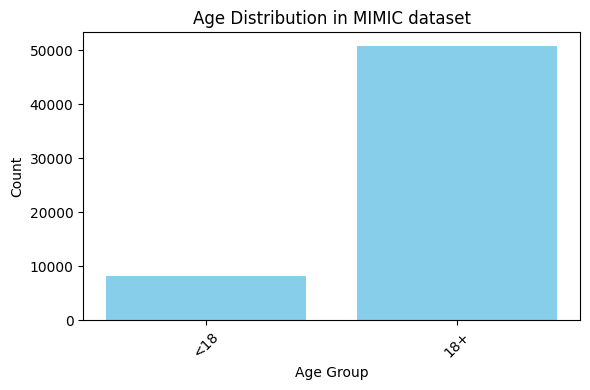

In [54]:
# Create a bar chart
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.bar(age_cat_counts.index, age_cat_counts.values, color='skyblue')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Distribution in MIMIC dataset')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

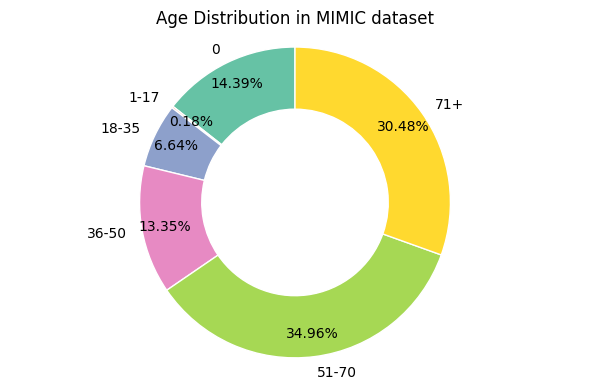

In [26]:
# Calculate the counts for each age group
age_group_counts = df_demographic_full['AGE_cat'].value_counts()

# Sort the age groups based on their labels
age_group_counts = age_group_counts.sort_index()

# Create a donut chart
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
colors = sns.color_palette("Set2")
plt.pie(age_group_counts.values, labels=age_group_counts.index, colors=colors, autopct='%1.2f%%', startangle=90,
        pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))

# Draw a white circle in the center to create the donut effect
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Add a title
plt.title('Age Distribution in MIMIC dataset')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

plt.tight_layout()
plt.show()

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


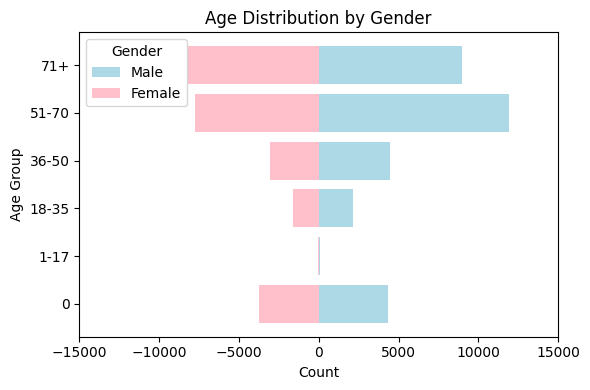

In [28]:
# Sort the DataFrame by 'AgeGroup' column
df_demographic_full.sort_values(by='AGE_cat', inplace=True)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Count the number of observations for each AgeGroup and GENDER
age_gender_counts = df_demographic_full.groupby(['AGE_cat', 'GENDER']).size().unstack().reset_index()

# Create side-by-side bars for males and females with opposite directions
ax.barh(age_gender_counts['AGE_cat'], age_gender_counts['M'], color="lightblue", label='Male')
ax.barh(age_gender_counts['AGE_cat'], -age_gender_counts['F'], color="pink", label='Female')

# Set labels, title, and legend
ax.set_xlabel('Count')
ax.set_ylabel('Age Group')
ax.set_title('Age Distribution by Gender')
ax.legend(title='Gender')

# Set symmetric x-axis limits
ax.set_xlim(-15000, 15000)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### 1.2.4 Discharge Location

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


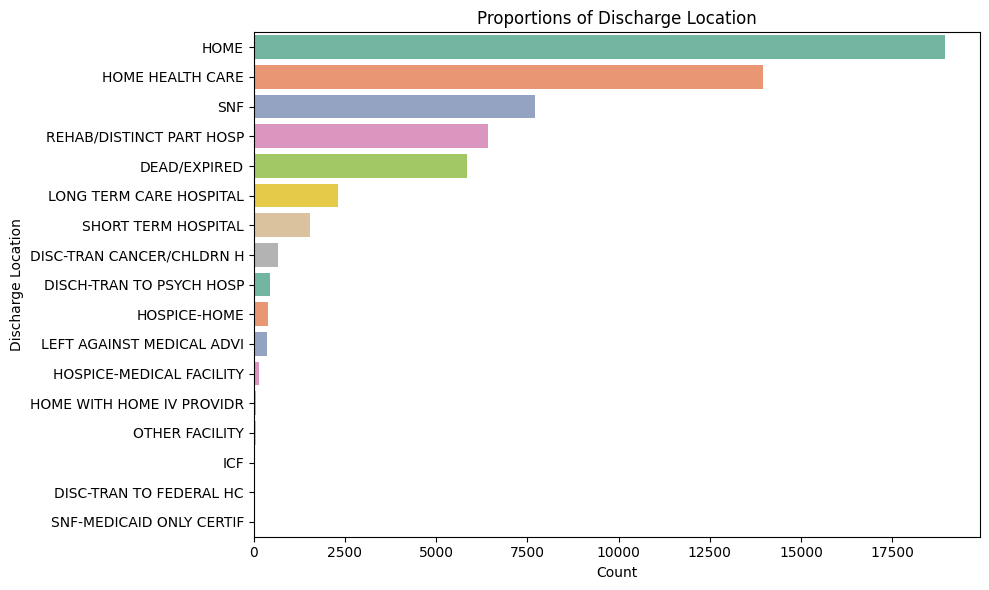

In [29]:
# Count the number of instances for each discharge location
discharge_location_counts = df_demographic_full["DISCHARGE_LOCATION"].value_counts()

# Create a figure and axis for the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for the chart
colors = sns.color_palette("Set2")

# Create a bar chart for discharge locations
sns.barplot(x=discharge_location_counts.values, y=discharge_location_counts.index, palette=colors, ax=ax)

# Set labels and title
ax.set_xlabel('Count')
ax.set_ylabel('Discharge Location')
ax.set_title('Proportions of Discharge Location')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## 1.3 Plots

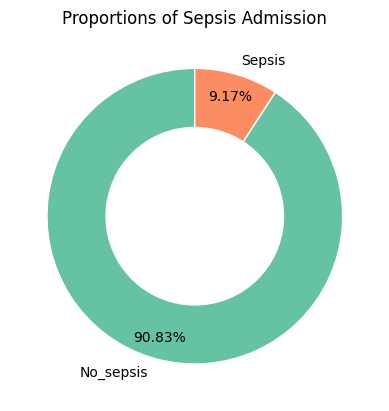

In [ ]:

# Plotting the counts in a donut chart
fig_donut, ax_donut = plt.subplots()

long_labels = df_demographic_full['IS_SEPSIS'].map(label_dict)
colors = sns.color_palette("Set2")
ax_donut.pie(label_counts, labels=long_labels.unique(), colors=colors,
             autopct='%1.2f%%', startangle=90, pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))
ax_donut.set_title("Proportions of Sepsis Admission")
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig_donut.gca().add_artist(centre_circle)
plt.show()

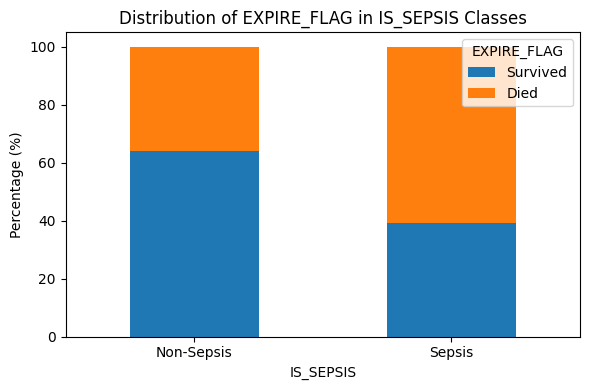

In [93]:
# Create a 100% stacked bar chart
fig, ax = plt.subplots(figsize=(6, 4))
crosstab_percentage.plot(kind="bar", stacked=True, ax=ax)

# Set labels and title
ax.set_xticklabels(['Non-Sepsis', 'Sepsis'], rotation=0)
ax.set_ylabel('Percentage (%)')
ax.set_title('Distribution of EXPIRE_FLAG in IS_SEPSIS Classes')

# Add a legend
ax.legend(title='EXPIRE_FLAG', labels=['Survived', 'Died'], loc='upper right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

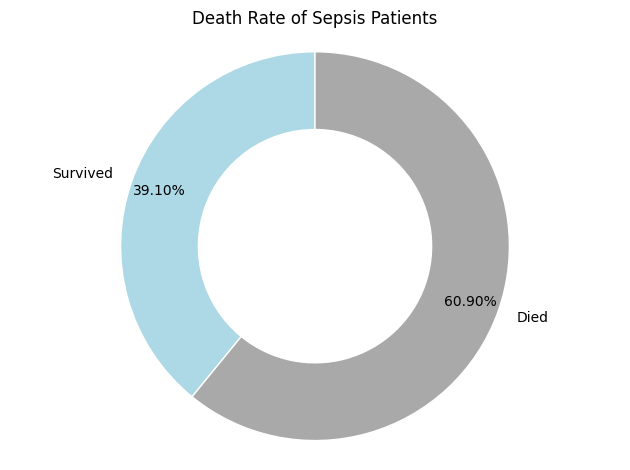

In [ ]:
# Filter the DataFrame for sepsis patients (IS_SEPSIS=1) who have died (EXPIRE_FLAG=1)
sepsis_expire_counts = df_demographic_full[(df_demographic_full['IS_SEPSIS'] == 1) & (df_demographic_full['EXPIRE_FLAG'] == 1)]

# Count the number of instances
death_count = len(sepsis_expire_counts)

# Count the number of sepsis patients
sepsis_patient_count = len(df_demographic_full[df_demographic_full['IS_SEPSIS'] == 1])

# Calculate the survival rate
survival_rate = (sepsis_patient_count - death_count) / sepsis_patient_count
death_rate = 1 - survival_rate

# Create a figure and axis for the donut chart
fig_donut, ax_donut = plt.subplots()

# Define labels and colors for the chart
labels = ['Survived', 'Died']
colors = ['lightblue', 'darkgrey']

# Plot the counts in a donut chart
ax_donut.pie([survival_rate, death_rate], labels=labels, colors=colors,
              autopct='%1.2f%%', startangle=90, pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))
ax_donut.set_title("Death Rate of Sepsis Patients")

# Create a white circle in the center to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig_donut.gca().add_artist(centre_circle)

# Adjust layout and show the plot
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.tight_layout()
plt.show()

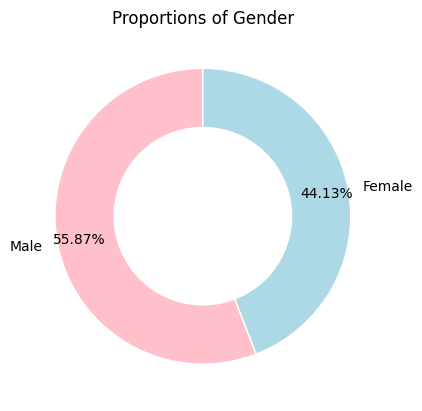

In [119]:
# Plotting the counts in a donut chart
gender_fig_donut, gender_ax_donut = plt.subplots()
gender_colors = ["pink",'lightblue']
gender_ax_donut.pie(gender_counts, labels=gender_long_labels.unique(), colors=gender_colors,
             autopct='%1.2f%%', startangle=90, pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))
gender_ax_donut.set_title("Proportions of Gender")
centre_circle = plt.Circle((0,0),0.60,fc='white')
gender_fig_donut.gca().add_artist(centre_circle)
plt.show()

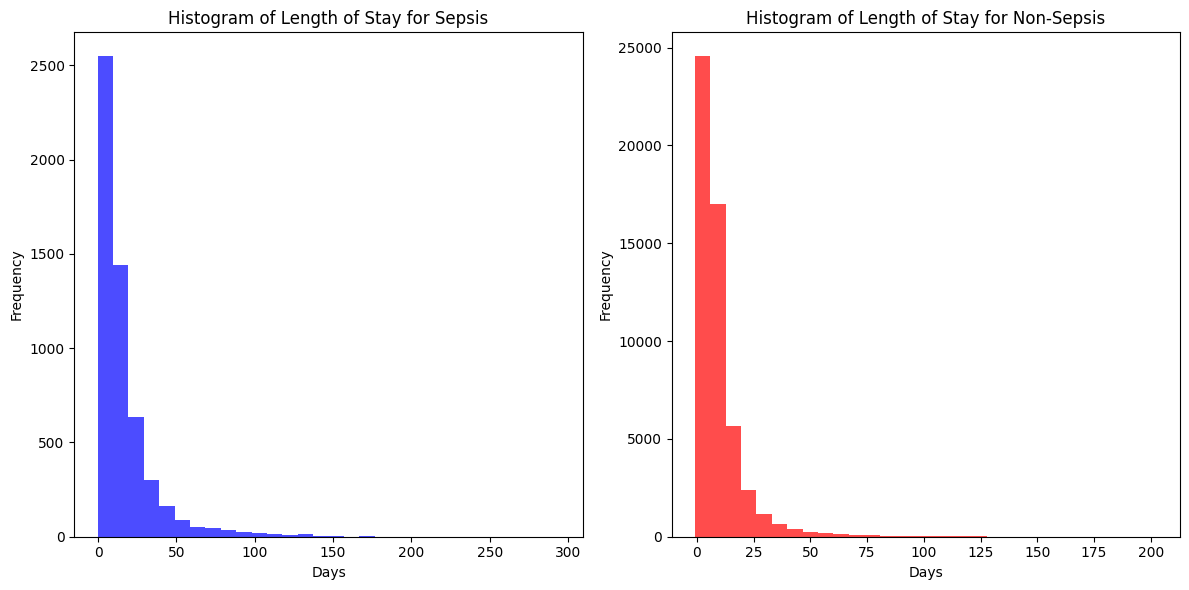

NameError: name 'sepsis_group' is not defined

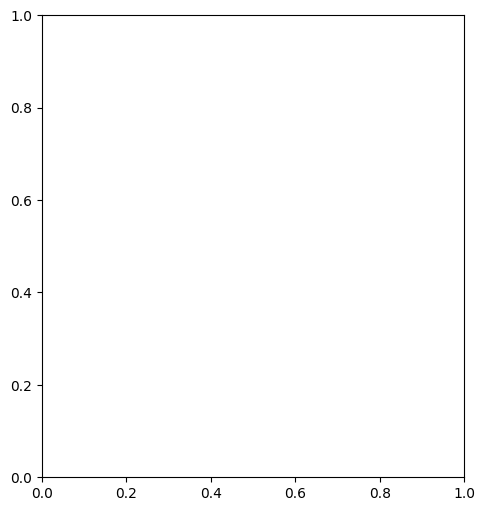

In [197]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Histogram
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(stay_sepsis, bins=30, color='blue', alpha=0.7, label='Sepsis')
plt.title('Histogram of Length of Stay for Sepsis')
plt.xlabel('Days')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(stay_non_sepsis, bins=30, color='red', alpha=0.7, label='Non-Sepsis')
plt.title('Histogram of Length of Stay for Non-Sepsis')
plt.xlabel('Days')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Q-Q plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
stats.probplot(sepsis_group, plot=plt)
plt.title('Q-Q Plot for Sepsis')

plt.subplot(1, 2, 2)
stats.probplot(non_sepsis_group, plot=plt)
plt.title('Q-Q Plot for Non-Sepsis')

plt.tight_layout()
plt.show()


## Estimating labevents time interval

In [30]:
# Compute STAY_DURATION as CHARTTIME - ADMITTIME
combined_df['STAY_DURATION'] = (combined_df['CHARTTIME'] - combined_df['ADMITTIME']).dt.total_seconds() / 3600  # duration in hours

# Compute BEFORE_DISCHARGE as DISCHTIME - CHARTTIME
combined_df['BEFORE_DISCHARGE'] = (combined_df['CHARTTIME'] - combined_df['DISCHTIME']).dt.total_seconds() / 3600  # duration in hours

In [31]:
# First, sort the dataframe by HADM_ID and CHARTTIME
combined_df = combined_df.sort_values(by=['SUBJECT_ID', 'HADM_ID', 'CHARTTIME'])

# Generate a unique TEST_NO for each CHARTTIME within HADM_ID
combined_df['TEST_NO'] = combined_df.groupby(['HADM_ID', 'CHARTTIME']).ngroup() + 1

# To get the test number only considering HADM_ID:
combined_df['TEST_NO'] = combined_df.groupby('HADM_ID')['CHARTTIME'].transform(lambda x: x.rank(method='dense')).astype(int)

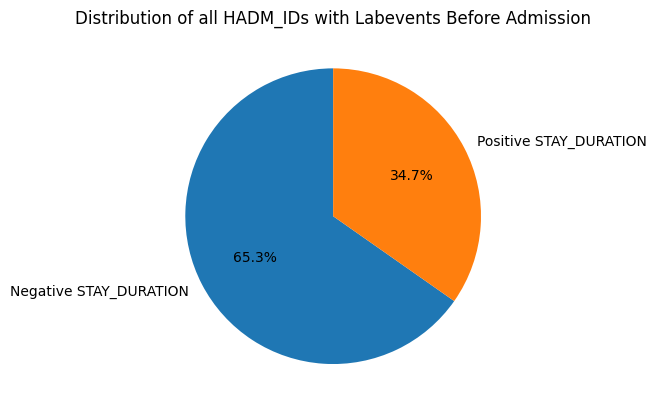

In [32]:
# Filter for rows where TEST_NO == 1
test_no_1_df = combined_df[combined_df['TEST_NO'] == 1]

# Count unique HADM_IDs for negative and positive STAY_DURATION
negative_hadm_count = test_no_1_df[test_no_1_df['STAY_DURATION'] < 0]['HADM_ID'].nunique()
positive_hadm_count = test_no_1_df[test_no_1_df['STAY_DURATION'] >= 0]['HADM_ID'].nunique()

# Data to plot
labels = ['Negative STAY_DURATION', 'Positive STAY_DURATION']
sizes = [negative_hadm_count, positive_hadm_count]

# Plot pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of all HADM_IDs with Labevents Before Admission")
plt.show()

In [33]:
# Create a mapping of HADM_ID to CHARTTIME when TEST_NO is 1
charttime_mapping = combined_df[combined_df['TEST_NO'] == 1].set_index('HADM_ID')['CHARTTIME'].to_dict()

# For rows where STAY_DURATION < 0, replace ADMITTIME with the corresponding CHARTTIME from the mapping
mask = combined_df['STAY_DURATION'] < 0
combined_df.loc[mask, 't0'] = combined_df.loc[mask, 'HADM_ID'].map(charttime_mapping)

# For other rows, set 't0' as 'ADMITTIME'
combined_df['t0'] = combined_df['t0'].fillna(combined_df['ADMITTIME'])

# Add another column "UPDATED_STAY" with the updated t0
combined_df['UPDATED_STAY'] = (combined_df['CHARTTIME'] - combined_df['t0']).dt.total_seconds() / 3600  # duration in hours

# Compute TOTAL_STAY as DISCHTIME - t0
combined_df['TOTAL_STAY'] = (combined_df['DISCHTIME'] - combined_df['t0']).dt.total_seconds() / 3600  # duration in hours

In [34]:
# Round up to 1
combined_df['STAY_DURATION'] = np.ceil(combined_df['STAY_DURATION'])
combined_df['BEFORE_DISCHARGE'] = np.ceil(combined_df['BEFORE_DISCHARGE'])
combined_df['TOTAL_STAY'] = np.ceil(combined_df['TOTAL_STAY'])
combined_df['UPDATED_STAY'] = np.ceil(combined_df['UPDATED_STAY'])

In [35]:
selected_columns = ['STAY_DURATION', 'BEFORE_DISCHARGE', 'TOTAL_STAY', 'UPDATED_STAY']
pd.set_option('display.float_format', '{:.2f}'.format)
combined_df[selected_columns].describe()

,STAY_DURATION,BEFORE_DISCHARGE,TOTAL_STAY,UPDATED_STAY
count,22264050.00,22264050.00,22264050.00,22264050.00
mean,204.63,-318.05,523.48,204.94
std,327.39,400.97,565.69,327.20
min,-59.00,-7068.00,-22.00,0.00
25%,23.00,-390.00,184.00,23.00
50%,96.00,-191.00,346.00,96.00
75%,252.00,-96.00,656.00,252.00
max,7064.00,1245.00,7072.00,7064.00


In [36]:
combined_df

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,ADMITTIME,DISCHTIME,IS_SEPSIS,STAY_DURATION,BEFORE_DISCHARGE,TEST_NO,t0,UPDATED_STAY,TOTAL_STAY
435,1,2,163353,51143,2138-07-17 20:48:00,0,0.00,%,NaN,2138-07-17 19:04:00,2138-07-21 15:48:00,0,2.00,-91.00,1,2138-07-17 19:04:00,2.00,93.00
436,2,2,163353,51144,2138-07-17 20:48:00,0,0.00,%,NaN,2138-07-17 19:04:00,2138-07-21 15:48:00,0,2.00,-91.00,1,2138-07-17 19:04:00,2.00,93.00
437,3,2,163353,51146,2138-07-17 20:48:00,0,0.00,%,NaN,2138-07-17 19:04:00,2138-07-21 15:48:00,0,2.00,-91.00,1,2138-07-17 19:04:00,2.00,93.00
438,4,2,163353,51200,2138-07-17 20:48:00,0,0.00,%,NaN,2138-07-17 19:04:00,2138-07-21 15:48:00,0,2.00,-91.00,1,2138-07-17 19:04:00,2.00,93.00
439,5,2,163353,51221,2138-07-17 20:48:00,0,0.00,%,abnormal,2138-07-17 19:04:00,2138-07-21 15:48:00,0,2.00,-91.00,1,2138-07-17 19:04:00,2.00,93.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22145759,27907645,99999,113369,51250,2118-01-02 05:30:00,93,93.00,fL,NaN,2117-12-30 07:15:00,2118-01-04 16:30:00,0,71.00,-59.00,6,2117-12-30 07:15:00,71.00,130.00
22145760,27907646,99999,113369,51265,2118-01-02 05:30:00,193,193.00,K/uL,NaN,2117-12-30 07:15:00,2118-01-04 16:30:00,0,71.00,-59.00,6,2117-12-30 07:15:00,71.00,130.00
22145761,27907647,99999,113369,51277,2118-01-02 05:30:00,12.9,12.90,%,NaN,2117-12-30 07:15:00,2118-01-04 16:30:00,0,71.00,-59.00,6,2117-12-30 07:15:00,71.00,130.00
22145762,27907648,99999,113369,51279,2118-01-02 05:30:00,3.03,3.03,m/uL,abnormal,2117-12-30 07:15:00,2118-01-04 16:30:00,0,71.00,-59.00,6,2117-12-30 07:15:00,71.00,130.00


In [37]:
# Calculate the number of labevents per hour
labevent_counts = combined_df.groupby('UPDATED_STAY').size().reset_index(name='counts')

# Extract columns and drop duplicates
unique_hadm_df = combined_df[['HADM_ID', 'TOTAL_STAY']].drop_duplicates()

# List to store results
results = []

# Iterate over each UPDATED_STAY
for updated_stay in combined_df['UPDATED_STAY'].unique():
    count = unique_hadm_df[unique_hadm_df['TOTAL_STAY'] > updated_stay]['HADM_ID'].nunique()
    results.append((updated_stay, count))

# Convert results to dataframe
result_df = pd.DataFrame(results, columns=['UPDATED_STAY', 'unique_hadm_count'])

In [38]:
merged_data = labevent_counts.merge(result_df, on='UPDATED_STAY')
merged_data['avg'] = merged_data['counts'] / merged_data['unique_hadm_count']
merged_data

,UPDATED_STAY,counts,unique_hadm_count,avg
0,0.00,1130268,58129,19.44
1,1.00,577510,58113,9.94
2,2.00,407997,58070,7.03
3,3.00,342910,58002,5.91
4,4.00,289722,57963,5.00
...,...,...,...,...
4261,7013.00,25,1,25.00
4262,7019.00,9,1,9.00
4263,7037.00,31,1,31.00
4264,7060.00,20,1,20.00


/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/amyhung/Documents/CITS5553

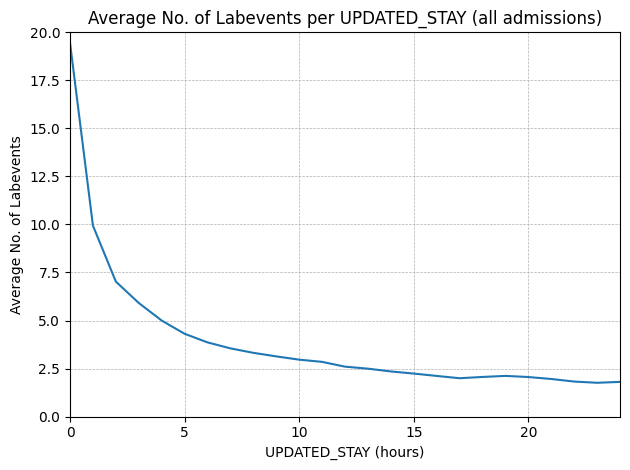

In [39]:
# Plotting the line chart
sns.lineplot(x='UPDATED_STAY', y='avg', data=merged_data)

plt.title('Average No. of Labevents per UPDATED_STAY (all admissions)')
plt.xlabel('UPDATED_STAY (hours)')
plt.ylabel('Average No. of Labevents')
plt.xlim((0, 24))
plt.ylim((0, 20))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amyhung/Documents/CITS5553_project/d

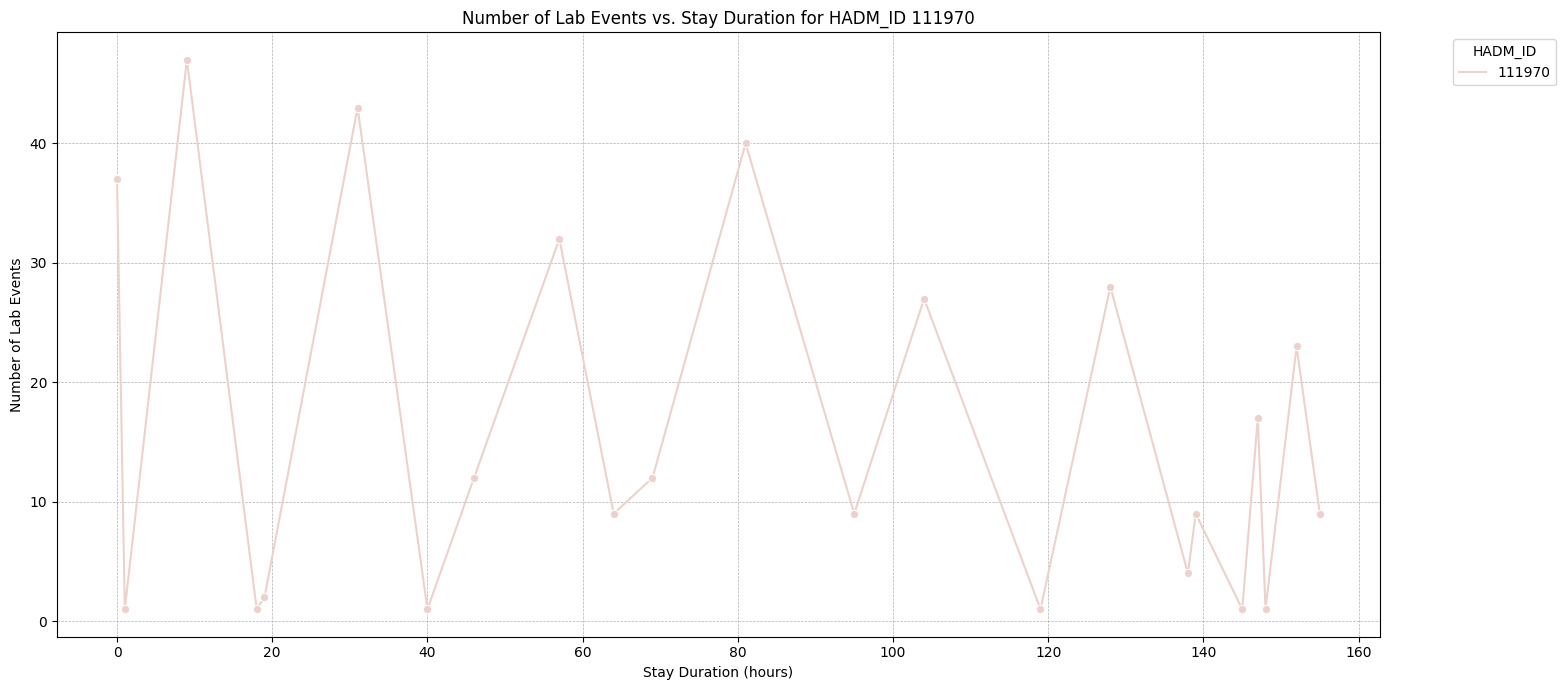

In [40]:
# Filter dataset for a specific HADM_ID
subject_data = combined_df[combined_df['HADM_ID'] == 111970]
grouped_subject_data = subject_data.groupby(['HADM_ID', 'UPDATED_STAY']).size().reset_index(name='counts')

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(x='UPDATED_STAY', y='counts', hue='HADM_ID', data=grouped_subject_data, marker='o')

plt.title('Number of Lab Events vs. Stay Duration for HADM_ID 111970')
plt.xlabel('Stay Duration (hours)')
plt.ylabel('Number of Lab Events')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.legend(title='HADM_ID', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.show()

In [41]:
# For sepsis admission only
sepsis_df = combined_df[combined_df["IS_SEPSIS"]== 1]

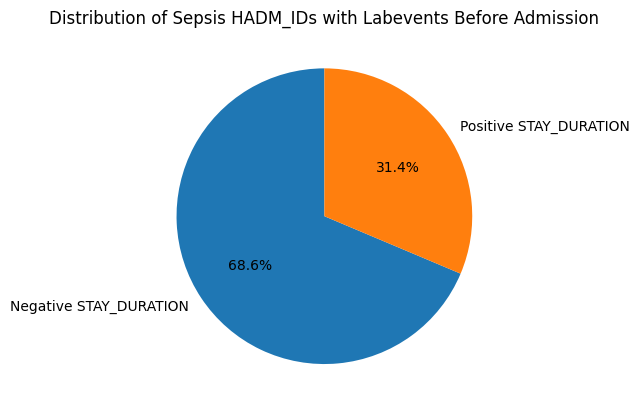

In [42]:
# Filter for rows where TEST_NO == 1
test_no_1_sepsis_df = sepsis_df[sepsis_df['TEST_NO'] == 1]

# Count unique HADM_IDs for negative and positive STAY_DURATION
negative_hadm_sepsis_count = test_no_1_sepsis_df[test_no_1_sepsis_df['STAY_DURATION'] < 0]['HADM_ID'].nunique()
positive_hadm_sepsis_count = test_no_1_sepsis_df[test_no_1_sepsis_df['STAY_DURATION'] >= 0]['HADM_ID'].nunique()

# Data to plot
labels = ['Negative STAY_DURATION', 'Positive STAY_DURATION']
sizes = [negative_hadm_sepsis_count, positive_hadm_sepsis_count]

# Plot pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Sepsis HADM_IDs with Labevents Before Admission")
plt.show()

In [43]:
# Calculate the number of labevents per hour
labevent_sepsis_counts = sepsis_df.groupby('UPDATED_STAY').size().reset_index(name='counts')

# Extract columns and drop duplicates
unique_sepsis_hadm_df = sepsis_df[['HADM_ID', 'TOTAL_STAY']].drop_duplicates()

# List to store results
results_sepsis = []

# Iterate over each UPDATED_STAY
for updated_stay in sepsis_df['UPDATED_STAY'].unique():
    count = unique_sepsis_hadm_df[unique_sepsis_hadm_df['TOTAL_STAY'] > updated_stay]['HADM_ID'].nunique()
    results_sepsis.append((updated_stay, count))

# Convert results to dataframe
result_sepsis_df = pd.DataFrame(results_sepsis, columns=['UPDATED_STAY', 'unique_hadm_count'])

merged_sepsis_data = labevent_sepsis_counts.merge(result_sepsis_df, on='UPDATED_STAY')
merged_sepsis_data['avg'] = merged_sepsis_data['counts'] / merged_sepsis_data['unique_hadm_count']
merged_sepsis_data

,UPDATED_STAY,counts,unique_hadm_count,avg
0,0.00,142109,5398,26.33
1,1.00,78053,5396,14.46
2,2.00,51227,5392,9.50
3,3.00,44481,5385,8.26
4,4.00,36694,5383,6.82
...,...,...,...,...
4077,7013.00,25,1,25.00
4078,7019.00,9,1,9.00
4079,7037.00,31,1,31.00
4080,7060.00,20,1,20.00


/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/amyhung/Documents/CITS5553

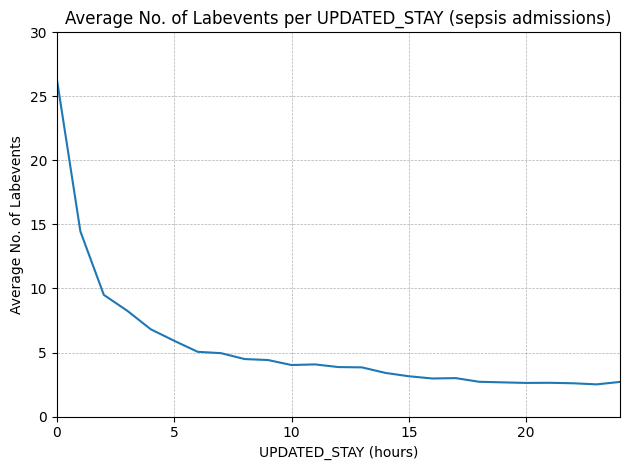

In [44]:
# Plotting the line chart
sns.lineplot(x='UPDATED_STAY', y='avg', data=merged_sepsis_data)

plt.title('Average No. of Labevents per UPDATED_STAY (sepsis admissions)')
plt.xlabel('UPDATED_STAY (hours)')
plt.ylabel('Average No. of Labevents')
plt.xlim((0, 24))
plt.ylim((0, 30))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Extracting Dataset

### 1. t0

In [45]:
# Extract input data at t = 0
key_features = [51279, 51222, 51221, 50931, 51006, 51244, 51256, 51301, 51274, 50912, 51237, 50893, 50882, 50813,
                50821, 51265, 50820, 50818, 51275, 51493]
key_df = combined_df[combined_df['ITEMID'].isin(key_features)]

# Extract those relevant columns
key_df = key_df[['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'VALUENUM', 'IS_SEPSIS', 'TEST_NO', 'UPDATED_STAY']]

# Filter rows where TEST_NO == 1
key_df = key_df[key_df['TEST_NO'] == 1]

key_df = key_df.merge(df_desc_labitems[['ITEMID', 'LABEL','FLUID']], on=['ITEMID'], how='left')

# Create NEW_VALUENUM column based on condition
key_df['NEW_VALUENUM'] = np.where(key_df['UPDATED_STAY'] == 0, key_df['VALUENUM'], -999)
key_df['ITEMID'] = key_df['FLUID'] + '_' + key_df['LABEL'] + '_' + key_df['ITEMID'].astype(str)

# Use pivot_table to reshape key_df
key_df_pivot = key_df.pivot_table(index=['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS', 'TEST_NO', 'UPDATED_STAY'], 
                                  columns='ITEMID', 
                                  values='NEW_VALUENUM', 
                                  aggfunc='first').reset_index()

key_df_pivot.columns.name = None  


In [46]:
# Fill -999 to missing values in ITEM_ID
columns_to_replace = key_df_pivot.columns[5:]

for col in columns_to_replace:
    key_df_pivot[col].fillna(-999, inplace=True)

# Removes irrelevant columns
key_df_pivot.drop(columns=['TEST_NO', 'UPDATED_STAY'], inplace=True)

In [47]:
t0_df = key_df_pivot.merge(df_demographic[['SUBJECT_ID', 'HADM_ID','AGE', 'GENDER']],on=['SUBJECT_ID', 'HADM_ID'],how='left')

# One-hot encoding GENDER
t0_df['GENDER_NUM'] = t0_df['GENDER'].replace({'M': 0, 'F': 1})
t0_df.drop(columns=["GENDER"], inplace=True)
t0_df = t0_df[t0_df['AGE'] >= 18]
t0_df

,SUBJECT_ID,HADM_ID,IS_SEPSIS,Blood_Bicarbonate_50882,"Blood_Calcium, Total_50893",Blood_Creatinine_50912,Blood_Glucose_50931,Blood_Hematocrit_51221,Blood_Hemoglobin_51222,Blood_INR(PT)_51237,...,Blood_Platelet Count_51265,Blood_Red Blood Cells_51279,Blood_Urea Nitrogen_51006,Blood_White Blood Cells_51301,Blood_pCO2_50818,Blood_pH_50820,Blood_pO2_50821,Urine_RBC_51493,AGE,GENDER_NUM
1,3,145834,0,25.00,8.20,3.20,91.00,30.20,10.00,1.30,...,282.00,3.44,53.00,12.70,-999.00,-999.00,-999.00,-999.00,76,0
2,4,185777,0,24.00,8.90,0.50,140.00,34.20,11.50,-999.00,...,207.00,3.80,9.00,9.70,-999.00,-999.00,-999.00,-999.00,47,1
4,6,107064,0,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,...,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,65,1
7,9,150750,0,30.00,-999.00,1.20,129.00,45.20,15.40,1.10,...,258.00,5.46,16.00,7.50,-999.00,-999.00,-999.00,-999.00,41,0
9,11,194540,0,25.00,-999.00,0.70,121.00,36.90,12.50,1.10,...,229.00,4.31,12.00,8.50,-999.00,-999.00,-999.00,-999.00,50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54780,99985,176670,1,-999.00,-999.00,-999.00,-999.00,36.40,12.40,-999.00,...,349.00,4.20,-999.00,13.00,-999.00,-999.00,-999.00,-999.00,53,0
54781,99991,151118,1,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,...,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,47,0
54782,99992,197084,0,22.00,7.10,1.20,206.00,12.90,4.70,1.10,...,188.00,1.35,56.00,21.40,-999.00,-999.00,-999.00,-999.00,65,1
54783,99995,137810,0,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,...,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,88,1


In [48]:
t0_df.to_csv('/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/data/t0_v3.csv', index=False)

### 2. t4

In [49]:
def get_admittime(x):
  x = x.sort_values(['CHARTTIME'])
  min_charttime = x.iloc[0].CHARTTIME
  new_admittime = x.iloc[0].ADMITTIME
  if min_charttime < new_admittime:
    new_admittime = min_charttime
  return new_admittime

# load features from file and get top 10 features
pontential_events = pd.read_csv(ROOT_DIR / 'data/potential_events.csv')
# pontential_events['ITEMID'] = pontential_events['ITEMID'].str.replace('"', '')
feature_list = pontential_events[pontential_events.GPT=='Y']['ITEMID']

# get all labevents rows filtered by itemid, t=n
def create_labevents_processed(hours=4):
  potential_cases = df_labevents[df_labevents.ITEMID.isin(feature_list)].merge(df_demographic[['SUBJECT_ID', 'HADM_ID', 'AGE', 'GENDER', 'ADMITTIME', 'IS_SEPSIS']], on=['SUBJECT_ID', 'HADM_ID'])

  # remove all patients with AGE < 18
  potential_cases = potential_cases[potential_cases['AGE'] >=18]

  # if CHARTTIME < ADMITTIME => ADMITTIME = CHARTTIME
  new_admittime = potential_cases.groupby(['SUBJECT_ID', 'HADM_ID']).apply(lambda x: get_admittime(x)).reset_index(name='NEW_ADMITTIME')
  potential_cases = potential_cases.merge(new_admittime, on=['SUBJECT_ID', 'HADM_ID'])

  # calculate TIME of test since ADMITTIME
  potential_cases['TIME'] = np.ceil((potential_cases.CHARTTIME - potential_cases.NEW_ADMITTIME).dt.total_seconds() / 3600)
  potential_cases = potential_cases[(potential_cases.TIME <= hours)]
  potential_cases = potential_cases.merge(df_desc_labitems[['ITEMID', 'LABEL', 'FLUID']], on=['ITEMID'])

  # One-hot encoding GENDER
  potential_cases['GENDER_NUM'] = potential_cases['GENDER'].replace({'M': 0, 'F': 1})
  potential_cases.drop(columns=["GENDER"], inplace=True)

  # out_file_abnormal = ROOT_DIR / 'data/output_csv/labevents_with_time.csv'
  # my_util.save_csv(potential_cases, out_file_abnormal)
  return potential_cases

a = create_labevents_processed()

In [53]:
def compute_feature_values(x):
  x.sort_values(['CHARTTIME'], ascending=False, inplace=True)
  try:
    value = x.loc[~x.VALUE.isna()].iloc[0]['VALUENUM']
  except:
    value = -999
  return value

df_final = a.drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID'], ignore_index=True)[['SUBJECT_ID', 'HADM_ID', 'AGE', 'IS_SEPSIS','GENDER_NUM']]

for itemid in feature_list:
  new_col = f'ITEMID_{itemid}'
  temp_df = a[a.ITEMID == itemid].groupby(['SUBJECT_ID', 'HADM_ID', 'ITEMID']).apply(lambda x: compute_feature_values(x)).reset_index(name=new_col)
  df_final = df_final.merge(temp_df[['SUBJECT_ID', 'HADM_ID', new_col]], on=['SUBJECT_ID', 'HADM_ID'], how='left')

df_final = df_final.fillna(-999)
#my_util.save_csv(df_final, ROOT_DIR / 'data/output_csv/train_data.csv')

In [54]:
df_final


,SUBJECT_ID,HADM_ID,AGE,IS_SEPSIS,GENDER_NUM,ITEMID_51279,ITEMID_51222,ITEMID_51221,ITEMID_50931,ITEMID_51006,...,ITEMID_50912,ITEMID_51237,ITEMID_50893,ITEMID_50882,ITEMID_50813,ITEMID_50821,ITEMID_51265,ITEMID_50820,ITEMID_50818,ITEMID_51275
0,3,145834.00,76,0,0,2.79,8.20,25.60,281.00,43.00,...,2.50,1.70,7.40,11.00,8.00,329.00,253.00,7.26,28.00,46.40
1,4,185777.00,47,0,1,3.80,11.50,34.20,140.00,9.00,...,0.50,1.00,8.90,24.00,-999.00,-999.00,207.00,-999.00,-999.00,31.30
2,9,150750.00,41,0,0,5.46,15.40,45.20,129.00,16.00,...,1.20,1.10,-999.00,30.00,-999.00,-999.00,258.00,-999.00,-999.00,21.70
3,11,194540.00,50,0,1,4.31,12.50,36.90,121.00,12.00,...,0.70,1.10,-999.00,25.00,-999.00,-999.00,229.00,-999.00,-999.00,28.30
4,13,143045.00,39,0,1,4.08,12.30,35.60,169.00,13.00,...,0.60,1.20,8.90,23.00,-999.00,-999.00,216.00,-999.00,-999.00,44.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46059,8666,129517.00,43,0,0,-999.00,-999.00,-999.00,-999.00,-999.00,...,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,7.41,-999.00,-999.00
46060,11861,120052.00,21,0,1,-999.00,-999.00,-999.00,-999.00,-999.00,...,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,7.22,-999.00,-999.00
46061,13542,115692.00,84,0,1,-999.00,-999.00,-999.00,-999.00,-999.00,...,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,7.51,-999.00,-999.00
46062,25337,116249.00,81,0,1,-999.00,-999.00,-999.00,-999.00,-999.00,...,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,7.44,-999.00,-999.00


In [55]:
df_final.to_csv('/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/data/t4.csv', index=False)

### 3. t2

In [57]:
a = create_labevents_processed(2)
df_final = a.drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID'], ignore_index=True)[['SUBJECT_ID', 'HADM_ID', 'AGE', 'GENDER_NUM', 'IS_SEPSIS']]

for itemid in feature_list:
  new_col = f'ITEMID_{itemid}'
  temp_df = a[a.ITEMID == itemid].groupby(['SUBJECT_ID', 'HADM_ID', 'ITEMID']).apply(lambda x: compute_feature_values(x)).reset_index(name=new_col)
  df_final = df_final.merge(temp_df[['SUBJECT_ID', 'HADM_ID', new_col]], on=['SUBJECT_ID', 'HADM_ID'], how='left')

df_final = df_final.fillna(-999)
df_final

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_51279,ITEMID_51222,ITEMID_51221,ITEMID_50931,ITEMID_51006,...,ITEMID_50912,ITEMID_51237,ITEMID_50893,ITEMID_50882,ITEMID_50813,ITEMID_50821,ITEMID_51265,ITEMID_50820,ITEMID_50818,ITEMID_51275
0,3,145834.00,76,0,0,3.44,10.00,30.20,91.00,53.00,...,3.20,1.30,8.20,25.00,-999.00,-999.00,282.00,-999.00,-999.00,30.70
1,4,185777.00,47,1,0,3.80,11.50,34.20,140.00,9.00,...,0.50,1.00,8.90,24.00,-999.00,-999.00,207.00,-999.00,-999.00,31.30
2,9,150750.00,41,0,0,5.46,15.40,45.20,129.00,16.00,...,1.20,1.10,-999.00,30.00,-999.00,-999.00,258.00,-999.00,-999.00,21.70
3,11,194540.00,50,1,0,4.31,12.50,36.90,121.00,12.00,...,0.70,1.10,-999.00,25.00,-999.00,-999.00,229.00,-999.00,-999.00,28.30
4,13,143045.00,39,1,0,4.08,12.30,35.60,169.00,13.00,...,0.60,1.20,8.90,23.00,-999.00,-999.00,216.00,-999.00,-999.00,44.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42739,2136,174241.00,64,0,0,-999.00,-999.00,-999.00,-999.00,-999.00,...,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,7.23,-999.00,-999.00
42740,11861,120052.00,21,1,0,-999.00,-999.00,-999.00,-999.00,-999.00,...,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,7.22,-999.00,-999.00
42741,25337,116249.00,81,1,0,-999.00,-999.00,-999.00,-999.00,-999.00,...,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,7.44,-999.00,-999.00
42742,30268,199151.00,42,0,0,-999.00,-999.00,-999.00,-999.00,-999.00,...,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,7.36,-999.00,-999.00


In [58]:
df_final.to_csv('/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/data/t2.csv', index=False)